<a href="https://colab.research.google.com/github/Ultiautomation/git-learning/blob/main/TImeseries_TBM_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow

## STOCK MARKET PRICE PREDICTION
#### Using Transformer based model and time to vec encoding technique

In [ ]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.15.0


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

<ipython-input-4-80c1f6a4a768>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Hyperparameters

In [ ]:
batch_size = 24
seq_len = 128    #(sequence length)
d_k = 256     #(dimension of key vectors)
d_v = 256     #(dimension of value vectors)
n_heads = 12     #(number of attention heads)
ff_dim =  256       #(dimension of the feedforward layer)

### Load Data

In [ ]:
# Load dataset
file_path = '/content/drive/MyDrive/data/deep learning /timeseries data/msft_raw.csv'
df = pd.read_csv(file_path, usecols=['DATE', 'OPCP', 'HPCP', 'LPCP', 'CPCP', 'VTCP'])
df

,DATE,OPCP,HPCP,LPCP,CPCP,VTCP
0,2000-02-29,45.87500,45.875000,44.43750,44.68750,58437400
1,2000-03-01,44.81250,47.046875,44.46875,45.40625,106889800
2,2000-03-02,45.90625,47.687500,45.56250,46.68750,106932600
3,2000-03-03,47.37500,49.437500,46.93750,48.06250,101435200
4,2000-03-06,48.00000,48.687500,45.06250,45.31250,93609400
...,...,...,...,...,...,...
5872,2023-07-03,339.19000,340.900000,336.57000,337.99000,12508700
5873,2023-07-05,335.09000,341.650000,334.73000,338.15000,18156200
5874,2023-07-06,337.30000,342.990000,335.50000,341.27000,28161200
5875,2023-07-07,339.32000,341.790000,337.00000,337.22000,21185300


In [ ]:
# Apply moving average with a window of 10 days to all columns
df[['OPCP', 'HPCP', 'LPCP', 'CPCP', 'VTCP']] = df[['OPCP', 'HPCP', 'LPCP', 'CPCP', 'VTCP']].rolling(10).mean()

In [ ]:
#Checking for missing data
print('My dataframe has null values:{}'.format(df.isnull().values.any()))
print('Shape of the dataframe: {}'.format(df.shape))

My dataframe has null values:True
Shape of the dataframe: (5877, 6)


In [ ]:
# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True)

print('THE SAMPLE DATASET DIMENSIONS : {}'.format(df.shape))
print(f"THE DATA IS FROM {df['DATE'].min()} to {df['DATE'].max()}")
df.head()

THE SAMPLE DATASET DIMENSIONS : (5868, 6)
THE DATA IS FROM 2000-03-13 to 2023-07-10


,DATE,OPCP,HPCP,LPCP,CPCP,VTCP
9,2000-03-13,47.318750,48.695312,46.39375,47.387500,93227499.0
10,2000-03-14,47.662500,49.070312,46.70625,47.675000,94732679.0
11,2000-03-15,47.909375,49.196875,46.94375,47.903125,89364499.0
12,2000-03-16,48.115625,49.262500,47.05000,48.003125,86401319.0
13,2000-03-17,48.140625,49.293750,47.08125,48.165625,84373959.0


### Plot daily closing price and volume of asset

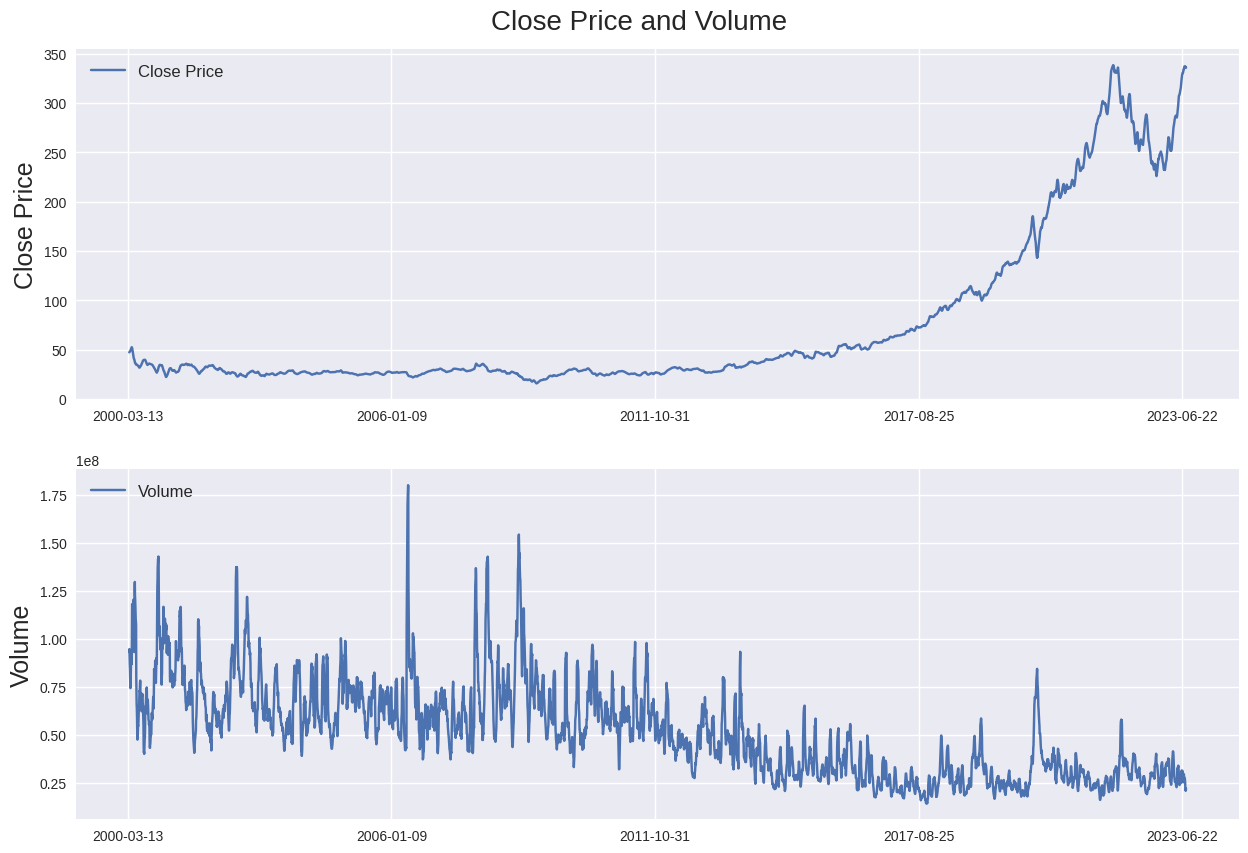

In [ ]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['CPCP'], label='Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['DATE'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['VTCP'], label='Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['DATE'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

### Computing percentage change for all features

In [ ]:
'''percentage change'''

df['OPCP'] = df['OPCP'].pct_change() # calculate returns column
df['HPCP'] = df['HPCP'].pct_change() # calculate returns column
df['LPCP'] = df['LPCP'].pct_change() # calculate returns column
df['CPCP'] = df['CPCP'].pct_change() # calculate returns column
df['VTCP'] = df['VTCP'].pct_change()
df.dropna(how='any', axis=0, inplace=True)

'''Create indexes to split dataset'''

time = sorted(df.index.values)
last_10pc = sorted(df.index.values)[-int(0.1*len(time))]
last_20pc = sorted(df.index.values)[-int(0.2*len(time))]

'''Normalize price columns'''

min_return = min(df[(df.index < last_20pc)][['OPCP', 'HPCP', 'LPCP', 'CPCP']].min(axis=0))
max_return = max(df[(df.index < last_20pc)][['OPCP', 'HPCP', 'LPCP', 'CPCP']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['OPCP'] = (df['OPCP'] - min_return) / (max_return - min_return)
df['HPCP'] = (df['HPCP'] - min_return) / (max_return - min_return)
df['LPCP'] = (df['LPCP'] - min_return) / (max_return - min_return)
df['CPCP'] = (df['CPCP'] - min_return) / (max_return - min_return)

'''Normalize volume column'''

min_volume = df[(df.index < last_20pc)]['VTCP'].min(axis=0)
max_volume = df[(df.index < last_20pc)]['VTCP'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['VTCP'] = (df['VTCP'] - min_volume) / (max_volume - min_volume)

'''Create training, validation and test split'''

df_train = df[(df.index < last_20pc)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pc) & (df.index < last_10pc)]
df_test = df[(df.index >= last_10pc)]

# Remove date column
df_train.drop(columns=['DATE'], inplace=True)
df_val.drop(columns=['DATE'], inplace=True)
df_test.drop(columns=['DATE'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (4694, 5)
Validation data shape: (587, 5)
Test data shape: (586, 5)


,OPCP,HPCP,LPCP,CPCP,VTCP
10,0.632473,0.638753,0.624864,0.615239,0.247681
11,0.602470,0.565047,0.601107,0.596790,0.198640
12,0.589883,0.547127,0.560502,0.557972,0.214474
13,0.535408,0.537060,0.537489,0.576646,0.221003
14,0.569034,0.562598,0.625359,0.628768,0.200217


### Moving Average - Plot daily changes of close price and volume

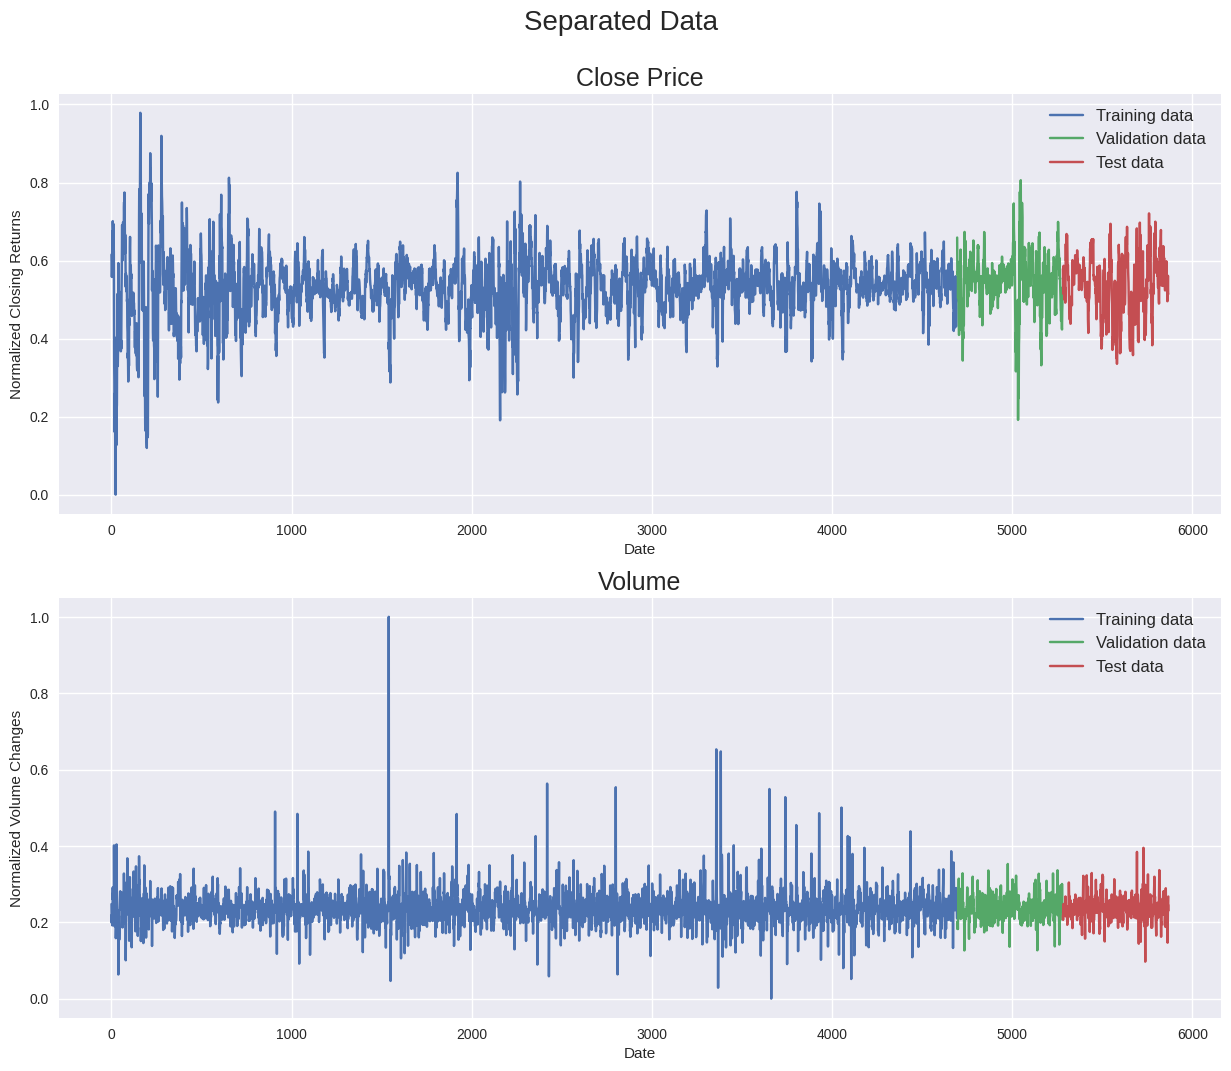

In [ ]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Separated Data", fontsize=20)
st.set_y(0.95)

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['CPCP'], label='Training data')

ax1.plot(np.arange(train_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]), df_val['CPCP'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['CPCP'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['VTCP'], label='Training data')

ax2.plot(np.arange(train_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]), df_val['VTCP'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['VTCP'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

In [ ]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # segments of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)



# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)



# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (4566, 128, 5) (4566,)
Validation set shape (459, 128, 5) (459,)
Testing set shape (458, 128, 5) (458,)


### Initiate Class for Time2Vec

In [ ]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

### Initiate class for Transformer

In [ ]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

    self.key = Dense(self.d_k,
                     input_shape=input_shape,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='glorot_uniform')

    self.value = Dense(self.d_v,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')
    #three dense layers are part of the self-attention mechanismand they project the input sequence into query, key, and value vectors
    #with a specific weight initialization technique known glorot initialization.

  def call(self, inputs): # assuming that the inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0]) # the query vectors are generated from the first sequence
    k = self.key(inputs[1]) # the key vectors are generated from the second sequence

    attn_weights = tf.matmul(q, k, transpose_b=True) # Computing the attention scores by taking the dot product. second matrix (k) should be transposed.
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights) # scaling the attention scores by dividing them by the square root of self.d_k
    attn_weights = tf.nn.softmax(attn_weights, axis=-1) # The attention scores are then passed through a softmax function along the last axis to obtain normalized attention weights

    v = self.value(inputs[2]) #the value vectors (v) are generated from the third sequence
    attn_out = tf.matmul(attn_weights, v) #the output is computed by taking the weighted sum of the value vectors based on the normalized attention weights.
    return attn_out

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
    self.linear = Dense(input_shape[0][-1],
                        input_shape=input_shape,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear


class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

### Define Model Function

In [ ]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model

In [ ]:
model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5',
                                              monitor='val_loss',
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=25,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

model = tf.keras.models.load_model('Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 5)]             0         []                            
                                                                                                  
 time2_vector (Time2Vector)  (None, 128, 2)               512       ['input_1[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 128, 7)               0         ['input_1[0][0]',             
                                                                     'time2_vector[0][0]']        
                                                                                                  
 transformer_encoder (Trans  (None, 128, 7)               99114     ['concatenate[0][0]',     

15/15 [==============================] - 3s 219ms/step
 
Evaluation metrics
Training Data - Loss: 0.0017, MAE: 0.0286, MAPE: 5.7745
Validation Data - Loss: 0.0019, MAE: 0.0306, MAPE: 5.9632
Test Data - Loss: 0.0019, MAE: 0.0340, MAPE: 6.6332


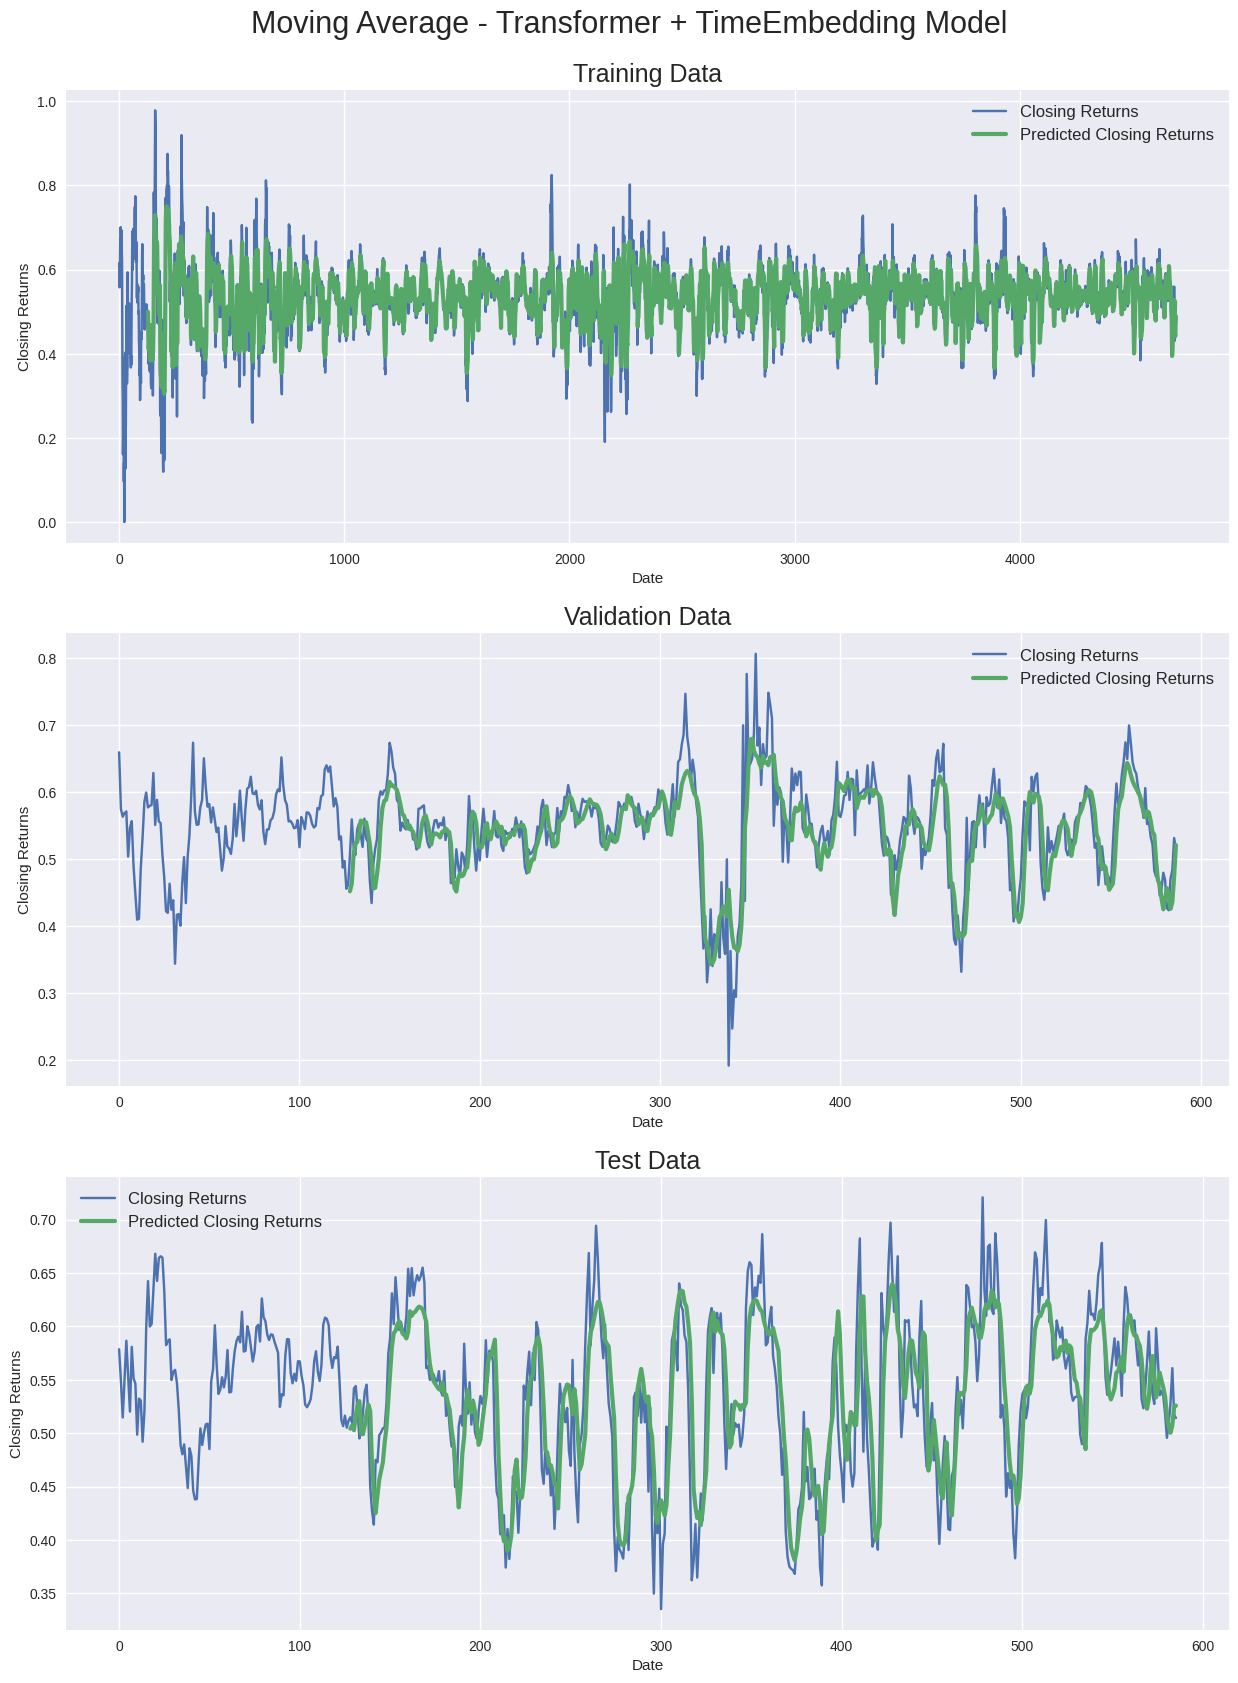

In [ ]:

'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))


'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Closing Returns')
ax31.legend(loc="best", fontsize=12)

In [ ]:
print(train_pred.shape)

(4566, 1)


### Implementing TPG

In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from scipy.stats import linregress

plt.style.use('ggplot')

In [ ]:
def sir_parameters(x,y): #sir stands for slope, intercept, rvalue (actually there's also the average trend line distance or avg_tld, but it came later)

  analytical_params = linregress(x, y)

  slope = analytical_params.slope
  intercept = analytical_params.intercept
  rvalue = analytical_params.rvalue #pay attention that here we have the correlaton coefficient (so not r2 that is the coefficient of determination)

  x_trend_line = slope*x + intercept #this is computed just for the avg_tld
  avg_trend_line_distance = np.mean(np.abs(x_trend_line-y))

  result = {
    'slope' : slope,
    'intercept': intercept,
    'rvalue**2': rvalue**2,
    'avg_trend_line_distance': avg_trend_line_distance
  }

  return result


Trained data

In [ ]:
x1= df.iloc[:4566, [0]]
x1["DATE"] = pd.to_datetime(x1["DATE"],format="%Y-%m-%d")
x = x1["DATE"].apply(lambda x: x.toordinal())
x = x.values

In [ ]:
y = train_pred
y = np.squeeze(y)

In [ ]:
y1 = val_pred
y1 = np.squeeze(y1)

In [ ]:
y2 = test_pred
y2 = np.squeeze(y2)

In [ ]:
sir_parameters(x,y)

{'slope': 1.850717223660838e-06,
 'intercept': -0.823150608780415,
 'rvalue**2': 0.0034800474825772286,
 'avg_trend_line_distance': 0.04643520975382284}

In [ ]:
train_pred

array([[0.49975416],
       [0.47605255],
       [0.43738782],
       ...,
       [0.46392873],
       [0.47412407],
       [0.4889122 ]], dtype=float32)

In [ ]:
print(val_pred.shape)
print(val_data.shape)

(459, 1)
(587, 5)


### Training data

In [ ]:
sir_parameters(x,y)

{'slope': 1.850717223660838e-06,
 'intercept': -0.823150608780415,
 'rvalue**2': 0.0034800474825772286,
 'avg_trend_line_distance': 0.04643520975382284}

In [ ]:
 #val_data = df[(df.index >= last_20pc) & (df.index < last_10pc)]
 #print(val_data.shape)
 #actual_target1 = val_data[['DATE','CPCP']]

(587, 6)


In [ ]:
 #test_data = df[df.index >= last_10pc]
 #print(test_data.shape)
 #actual_target2 = test_data[['DATE','CPCP']]

(586, 6)


In [ ]:
#print(actual_target1.shape)
#print(y1.shape)

(587,)
(459,)
